# Detección de Texto Generado por IA - Notebook de Análisis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

from transformers import AutoTokenizer, AutoModel
import torch


c:\Users\ddiaz\OneDrive\Documentos\UNIVERSIDAD EUROPEA\ENTREGABLES\TFM\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Carga y limpieza de datos

In [2]:
df = pd.read_csv("dataset_texto_ampliado.csv")

def limpiar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r"http\S+", "", texto)
    texto = re.sub(r"\d+", "", texto)
    texto = texto.translate(str.maketrans("", "", string.punctuation))
    return texto.strip()

df["texto_limpio"] = df["texto"].apply(limpiar_texto)


## Análisis Exploratorio

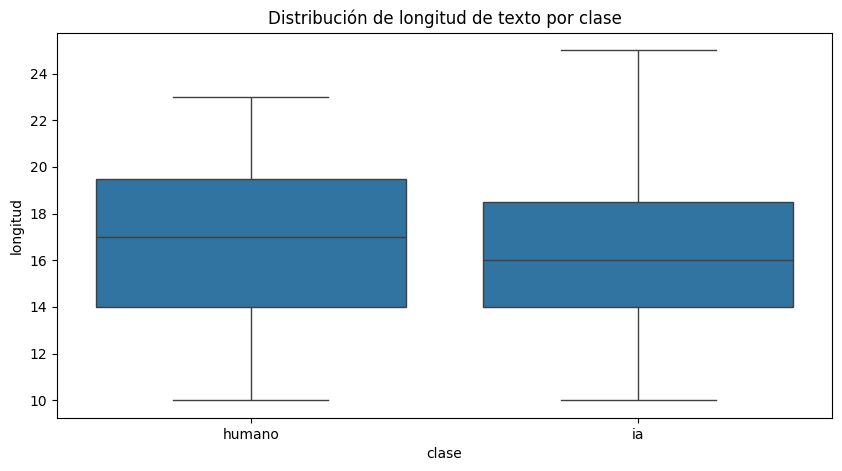

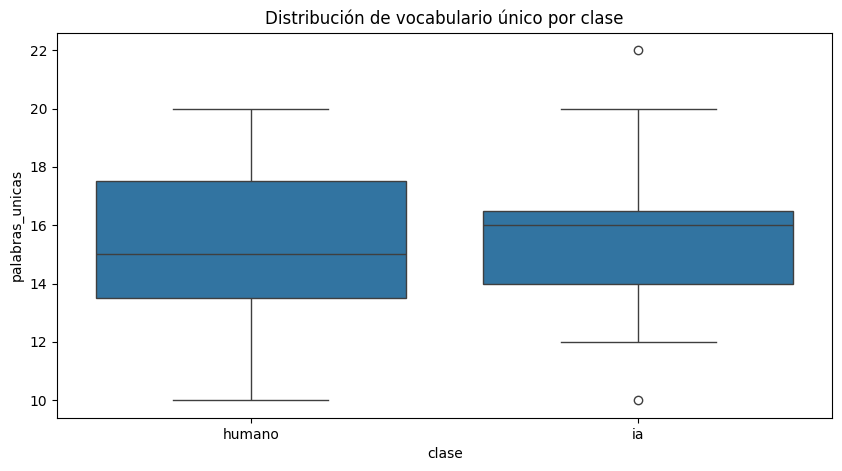

In [3]:
df["longitud"] = df["texto_limpio"].apply(lambda x: len(x.split()))
df["palabras_unicas"] = df["texto_limpio"].apply(lambda x: len(set(x.split())))

plt.figure(figsize=(10, 5))
sns.boxplot(x="clase", y="longitud", data=df)
plt.title("Distribución de longitud de texto por clase")
plt.savefig("boxplot_longitud.png")
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x="clase", y="palabras_unicas", data=df)
plt.title("Distribución de vocabulario único por clase")
plt.savefig("boxplot_vocab.png")
plt.show()


## Nube de palabras

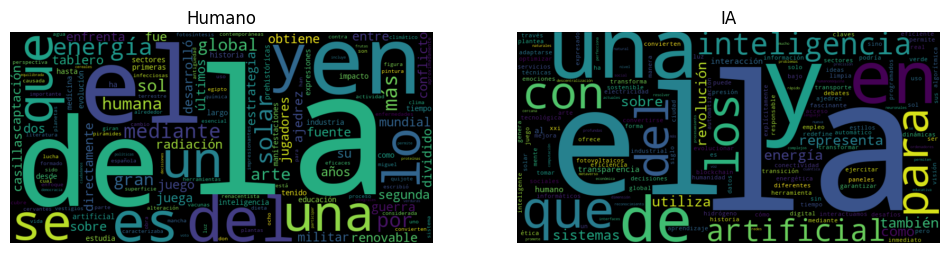

In [4]:
from wordcloud import WordCloud

texto_humano = " ".join(df[df["clase"] == "humano"]["texto_limpio"])
texto_ia = " ".join(df[df["clase"] == "ia"]["texto_limpio"])

wordcloud_humano = WordCloud(width=800, height=400).generate(texto_humano)
wordcloud_ia = WordCloud(width=800, height=400).generate(texto_ia)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_humano, interpolation='bilinear')
plt.axis("off")
plt.title("Humano")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_ia, interpolation='bilinear')
plt.axis("off")
plt.title("IA")
plt.savefig("nube_palabras.png")
plt.show()


## Extracción de Embeddings con BERT

In [5]:
tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")
model = AutoModel.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")

def obtener_embedding(texto):
    inputs = tokenizer(texto, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].numpy().flatten()

embeddings = np.array([obtener_embedding(t) for t in df["texto"]])
labels = df["clase"].values


Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Entrenamiento con Random Forest

              precision    recall  f1-score   support

      humano       0.80      0.80      0.80         5
          ia       0.75      0.75      0.75         4

    accuracy                           0.78         9
   macro avg       0.78      0.78      0.78         9
weighted avg       0.78      0.78      0.78         9



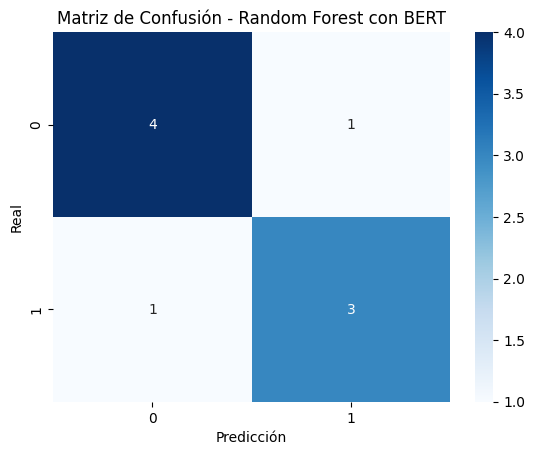

In [6]:
X_df = pd.DataFrame(embeddings, index=df.index)
y_series = pd.Series(labels, index=df.index)

X_train, X_test, y_train, y_test = train_test_split(
    X_df, y_series, test_size=0.3, stratify=y_series, random_state=42
)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión - Random Forest con BERT")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.savefig("matriz_confusion_bert_rf.png")
plt.show()


## Análisis de errores del modelo

In [8]:
errores = pd.DataFrame({
    "texto": df.loc[X_test.index, "texto"],
    "real": y_test,
    "pred": y_pred
})

errores_fallidos = errores[errores["real"] != errores["pred"]]

for _, fila in errores_fallidos.iterrows():
    print(f"🟥 [REAL: {fila['real']}] [PRED: {fila['pred']}]\n{fila['texto']}\n")
    print("-" * 80)


🟥 [REAL: humano] [PRED: ia]
En los últimos años, la inteligencia artificial ha tenido un gran impacto en sectores como la medicina, la educación y la industria.

--------------------------------------------------------------------------------
🟥 [REAL: ia] [PRED: humano]
La energía solar utiliza paneles fotovoltaicos que convierten la luz del Sol en electricidad de forma limpia y eficiente.

--------------------------------------------------------------------------------
